# Just some basic plots to put in the intro parts of the paper

In [27]:
import numpy as np
import pandas as pd
from glob import glob
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from MCMC_functions import *
from tqdm import tqdm
from scipy.stats import gaussian_kde
import pymc as pm
import arviz as az

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'


In [2]:
O3a_samples = glob('O3a-samples/*comoving.h5')
O3b_samples = glob('O3b-samples/*mixed_cosmo.h5')

print(len(O3a_samples))
print(len(O3b_samples))

39
36


In [46]:
n_dLs=10
n_mc = 8
n_events = len(O3a_samples)+len(O3b_samples)
n_dLs=10
n_mc = 8
m_min = 5
m_max = 120
dL_min = 100 #mpc
dL_max = 10000


In [47]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
# d_low_dl = dL[dL < cutoff_d]
# dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))
dL_cent = np.linspace(2000, 7000, n_dLs)

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

  0%|          | 0/8 [00:00<?, ?it/s]/Users/tanner/Research/Combined-O3ab/MCMC_functions.py:139: UserWarning: max occurs at grid boundary
  warnings.warn('max occurs at grid boundary')
100%|██████████| 8/8 [01:28<00:00, 11.06s/it]


(0.0, 12000.0)

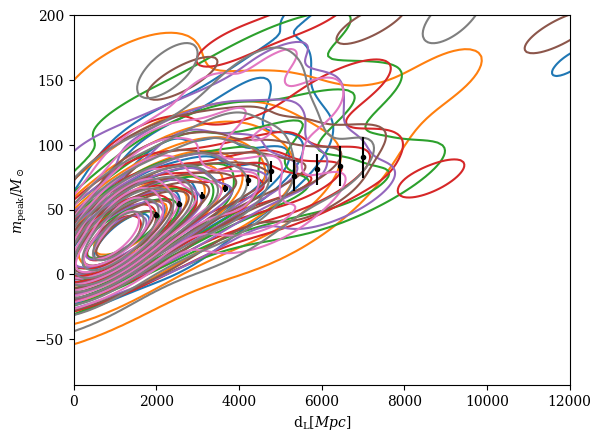

In [49]:
# m_errs = []
# dL_errs = []

for run in tqdm(range(n_mc)):
    mdets = []
    dL_s = []

    for f in O3a_samples:
        with h5py.File(f, 'r') as hf:
            posterior = np.array(hf['PublicationSamples/posterior_samples'])

            ind = np.random.randint(0, len(posterior))

            mdets.append(posterior['mass_1'][ind])
            dL_s.append(posterior['luminosity_distance'][ind])

    for f in O3b_samples:
        with h5py.File(f, 'r') as hf:            
            posterior = np.array(hf['C01:Mixed/posterior_samples'])

            ind = np.random.randint(0, len(posterior))

            mdets.append(posterior['mass_1'][ind])
            dL_s.append(posterior['luminosity_distance'][ind])
    
    arr = np.array([dL_s, mdets])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=dL_s, y=mdets)

plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
# plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=200)
plt.xlim(0, 12000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 93 seconds.


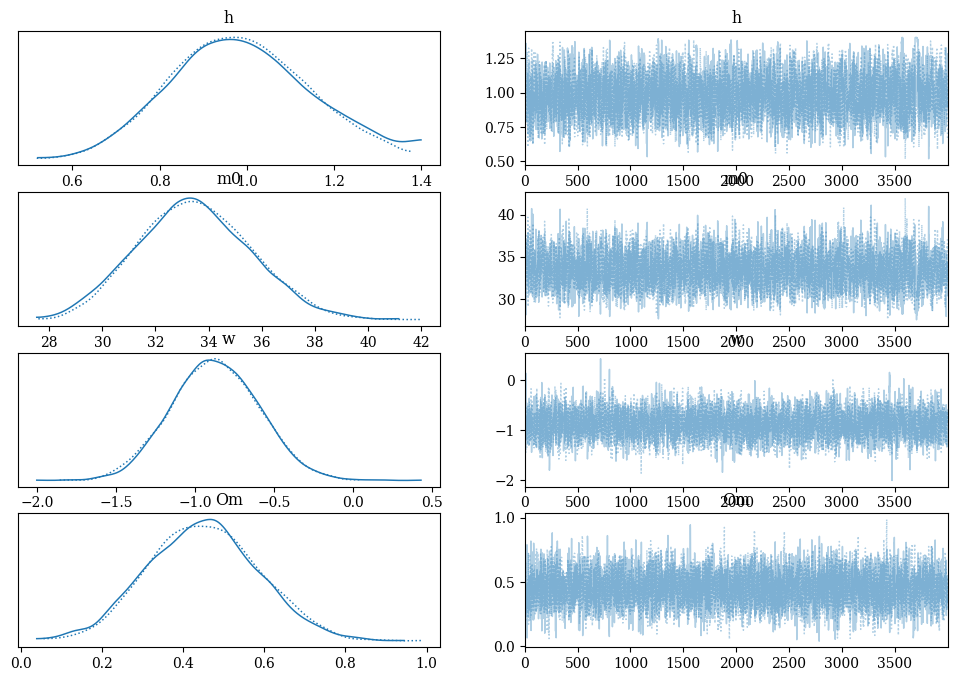

In [50]:
mu_ms = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(target_accept=0.95, tune=4000, draws=4000, init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

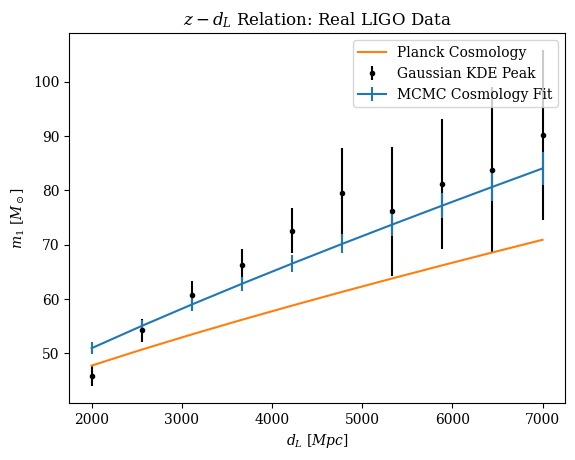

In [51]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")
plt.title(r"$z-d_L$ Relation: Real LIGO Data")
plt.ylabel(r"$m_1\ [M_\odot]$")
plt.xlabel(r"$d_L\ [Mpc]$")
plt.legend()

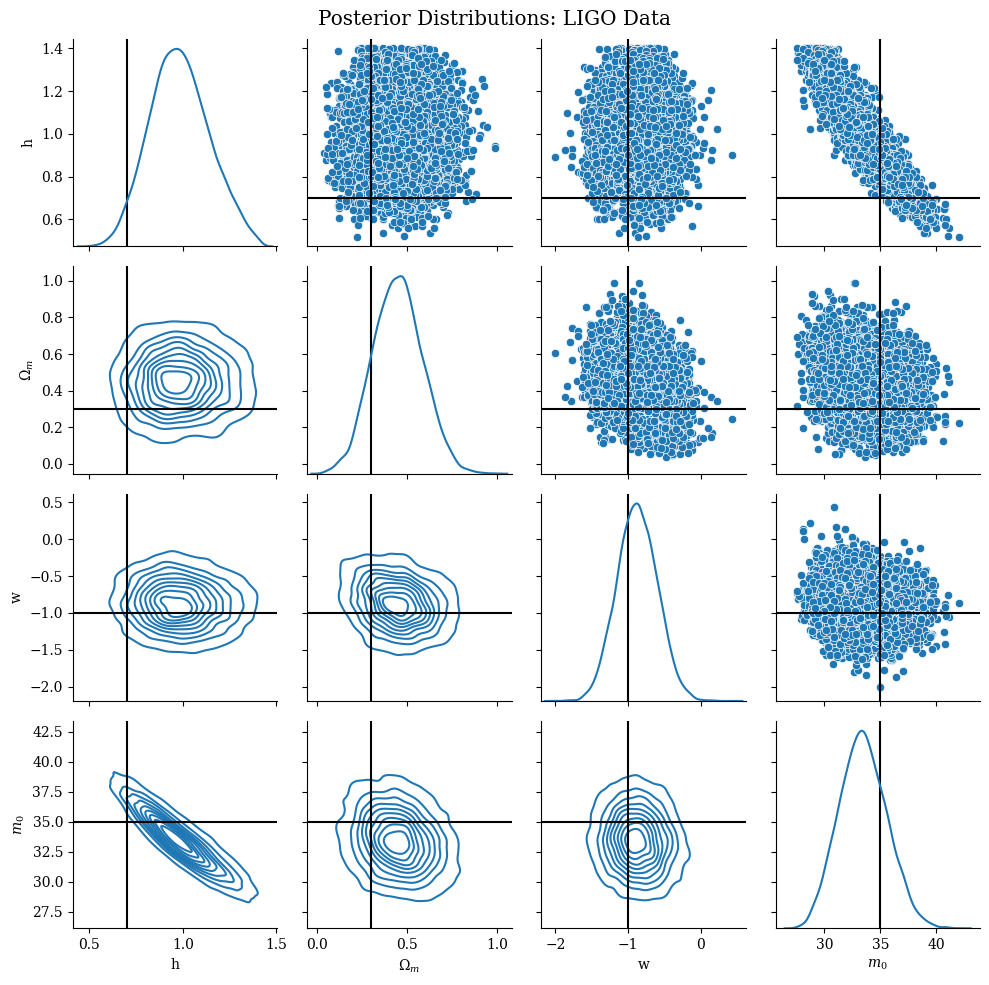

In [52]:
LIGO_df = trace.posterior[['h', 'Om', 'w', 'm0']].to_dataframe()

g = sns.PairGrid(LIGO_df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

replacements = {'Om': r'$\Omega_m$', 'm0': r'$m_0$'}
true_values = [0.7, 0.3, -1, 35]

for i in range(4):
    for j in range(4):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
        if i == j:
            # Diagonal plots
            g.axes[i,j].axvline(true_values[i], color='k')
        else:
            g.axes[i,j].axvline(true_values[j], color='k') # Not sure if this is the right ordering of i (rows) and j (cols)
            g.axes[i,j].axhline(true_values[i], color='k')
g.figure.suptitle("Posterior Distributions: LIGO Data", size='x-large')
g.figure.tight_layout()

In [6]:
m1 = generate_masses()
dL = generate_dLs()
z  = dLs_to_zs(dL)

m_det = m1*(1+z)

In [12]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dL)
dL_max = max(dL)
cutoff_d = 22000 #Mpc

In [14]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
# d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)
d_low_dl = dL[dL < cutoff_d]
dL_cent = np.quantile(d_low_dl, np.linspace(0.01, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

100%|██████████| 8/8 [01:59<00:00, 14.93s/it]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 168 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


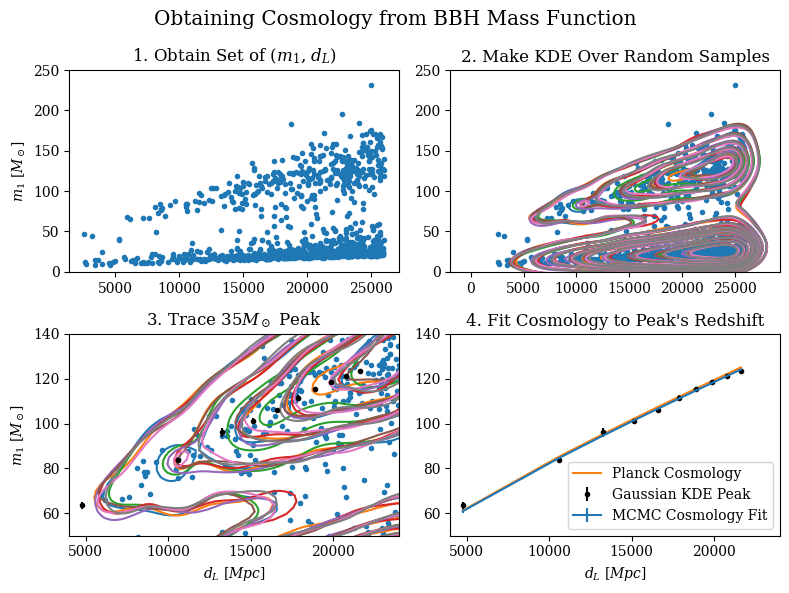

In [34]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
###NEEDS AXES LABELS
fig.suptitle("Obtaining Cosmology from BBH Mass Function", size='x-large')

axs[0,0].scatter(dL[::10], m_det[::10], marker='.')
axs[0,1].scatter(dL[::10], m_det[::10], marker='.')
axs[1,0].scatter(dL[::10], m_det[::10], marker='.')

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_dets = m_det[events]
    d_Ls = dL[events]
    d_Ls_mc = d_Ls[d_Ls < cutoff_d]
    m_det_mc = m_dets[d_Ls < cutoff_d]
    
    arr = np.array([d_Ls, m_dets])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls, y=m_dets, ax=axs[0,1])
    kplot = sns.kdeplot(x=d_Ls, y=m_dets, ax=axs[1,0])

axs[1,0].errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.',
               c='k')


mu_ms = np.mean(mpeak_samples, axis=0)
sigma_ms = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_ms, sigma_ms_obs=sigma_ms, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(target_accept=0.95, tune=4000, draws=4000, init='jitter+adapt_full')
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

axs[1,1].errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0),
             fmt='.', c='k', label="Gaussian KDE Peak")
axs[1,1].errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']),
              yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']),
              label="MCMC Cosmology Fit")
axs[1,1].plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value),
         label="Planck Cosmology")

axs[0,0].set_ylim(0,  250)
axs[0,1].set_ylim(0,  250)
axs[1,0].set_ylim(50, 140)
axs[1,1].set_ylim(50, 140)
axs[1,0].set_xlim(4000, 24000)
axs[1,1].set_xlim(4000, 24000)

axs[0,0].set_title(r"1. Obtain Set of ($m_1$, $d_L$)")
axs[0,1].set_title(r"2. Make KDE Over Random Samples")
axs[1,0].set_title(r"3. Trace $35M_\odot$ Peak")
axs[1,1].set_title(r"4. Fit Cosmology to Peak's Redshift")
axs[0,0].set_ylabel(r"$m_1\ [M_\odot]$")
axs[1,0].set_ylabel(r"$m_1\ [M_\odot]$")
axs[1,0].set_xlabel(r"$d_L\ [Mpc]$")
axs[1,1].set_xlabel(r"$d_L\ [Mpc]$")

axs[1,1].legend()
fig.tight_layout()